In [45]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn

import nltk
from nltk.translate.bleu_score import sentence_bleu

### 1.Load Image ans Caption Data

In [6]:
import json
caption_data_path = "/kaggle/input/news-image-caption-generation/caption_dataset_50k.json"

with open(caption_data_path, "r") as f:
    caption_data = json.load(f)

In [7]:
keys = list(caption_data.keys())
print(f"Total number of keys: {len(keys)}")
keys[0:10]

Total number of keys: 48273


['584f1ddf95d0e0392607597e',
 '54453eab38f0d832c813e7f5',
 '5a57160395d0e0110c1a3f23',
 '55b40f6b38f0d851b1f6dc7c',
 '51a92bb440e9ec65d203a9e4',
 '56562fe138f0d8310210dcbc',
 '58f7352c95d0e024b586c1c3',
 '5397a3d038f0d80b34dcbdd6',
 '549474a738f0d87118e48f39',
 '5812248995d0e022439c592f']

#### 1.1 Visualize an Image, caption and article

caption for the key: 584f1ddf95d0e0392607597e
: {'1': 'A woman grieved as she waited for the body of her husband to be retrieved from the scene of a multiple homicide at a house in Manila.', '0': 'The body of a man killed by unknown gunmen lay behind a convenience store in Manila.', '3': 'The funeral of Jimboy Bolasa, 25, who was found killed along with a friend.', '2': 'The body of a man killed by unidentified gunmen lay on a street in Mandaluyong, Philippines.'}

article for the key: 584f1ddf95d0e0392607597e
: His article reported that since the beginning of July, about 2,000 people had been killed by the police and that there had been more than 3,500 unsolved killings in the country. These figures match the numbers given to the news media by a Philippine police spokesman, Dionardo Carlos.

Mr. Andanar said that about a third of the unsolved killings had been identified as drug-related.

"The rest are murder and homicide cases perpetrated by riding-in-tandem gunmen which the Philippi

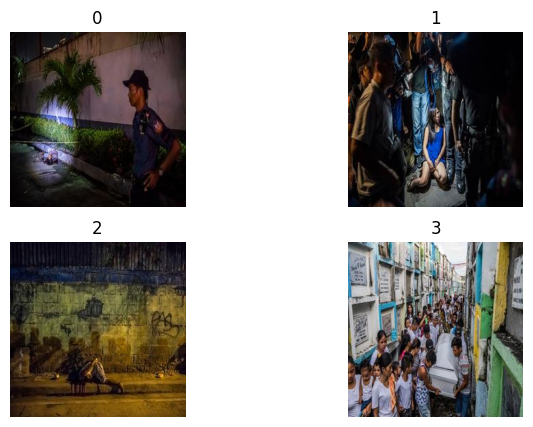

In [8]:
#print an image, caption and article correspoding to a key
from PIL import Image

key = "584f1ddf95d0e0392607597e"
image_path = "/kaggle/input/news-image-caption-generation/images_50k/new_images"
caption = caption_data.get(key)["image"]
article = caption_data.get(key)["article"]
    
print(f"caption for the key: {key}\n: {caption}\n")
print(f"article for the key: {key}\n: {article}\n")

fig,ax = plt.subplots(2,2, figsize=(8,5))
for i in range(len(caption)):
    image_dir = image_path + f"/{key}_{i}.jpg"
    img = Image.open(image_dir)
    print(img.height, img.width)
    ax[i//2, i%2].imshow(img)
    ax[i//2, i%2].axis("off")
    ax[i//2, i%2].set_title(f"{i}")
plt.show()

In [9]:
pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-odaqnjl7
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-odaqnjl7
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.9 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=9f27145cbabc5a0a2c39652d648474448cf64b431cc3de792808a0d14edefed5
  Stored in directory: /tmp/pip-ephem-wheel-cache-_k5xrriu/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
Note: you may need to restart the kernel to use updated packages.


In [10]:
# import torch
# import clip
# from PIL import Image

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model, preprocess = clip.load("ViT-B/32", device=device)

# image = preprocess(Image.open("/kaggle/input/news-image-caption-generation/images_50k/new_images/4fd101048eb7c8105d5bc251_0.jpg")).unsqueeze(0).to(device)
# text = clip.tokenize().to(device)

# with torch.no_grad():
#     image_features = model.encode_image(image)
#     text_features = model.encode_text(text)
    
#     logits_per_image, logits_per_text = model(image, text)
#     probs = logits_per_image.softmax(dim=-1).cpu().numpy()

# print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

In [11]:
import os
import clip
import torch
from torchvision.datasets import CIFAR100

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Download the dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

# Prepare the inputs
image, class_id = cifar100[3637]
image_input = preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 83.4MiB/s]


100%|██████████| 169001437/169001437 [00:02<00:00, 79881299.15it/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache

Top predictions:

           snake: 65.31%
          turtle: 12.29%
    sweet_pepper: 3.83%
          lizard: 1.88%
       crocodile: 1.75%


### Step 01: Construction Knowledge prompt 

In [12]:
import spacy

#function to get NER
import spacy

def extract_entity_contexts_with_ner(text, model="en_core_web_sm"):
    # Load spaCy model
    nlp = spacy.load(model)
    doc = nlp(text)
    
    entity_contexts = []
    ner = []
    for ent in doc.ents:
        start_token_idx = ent.start
        end_token_idx = ent.end
        # Extend the context by 3 tokens on each side of the named entity
        start_context_idx = max(0, start_token_idx - 3)
        end_context_idx = min(len(doc), end_token_idx + 3)
        sub_sentence = doc[start_context_idx:end_context_idx].text
        entity_contexts.append((ent.text, sub_sentence))
        ner.append(ent.text)
    return ner, entity_contexts


#function to get knowledge prompt
def generate_knowledge_prompts(entity_contexts):
    prompts = []
    for entity, context in entity_contexts:
        prompt = f"Generate a summary based on the named entity: {entity} based on the news context: {context}"
        prompts.append(prompt)
    return prompts


In [13]:
# Example usage:
news_article = "Fantasy football analysis for Thursday's three games. Check back Friday for analysis of Sunday's games and Monday's matchup between the Baltimore Ravens and the Cleveland Browns. You can also follow the Sablich brothers on Twitter at @5thDownFantasy.Matthew Stafford (DET) -- After two of his best performances of the season, Stafford has the fortune of playing a reeling Eagles defense that has allowed 10 passing touchdowns over the past three games, including five last weekend to Tampa Bay's Jameis Winston."
ner, entity_contexts = extract_entity_contexts_with_ner(news_article)
print("Named Entities:", entity_contexts)
knowledge_prompt = generate_knowledge_prompts(entity_contexts)
print("Knowledge Prompt:")

for prompt in knowledge_prompt:
    print(prompt)
    print()

Named Entities: [('Thursday', "football analysis for Thursday's three games"), ('three', "for Thursday's three games. Check"), ('Friday', '. Check back Friday for analysis of'), ('Sunday', "for analysis of Sunday's games and"), ('Monday', "'s games and Monday's matchup between"), ('Baltimore Ravens', 'matchup between the Baltimore Ravens and the Cleveland'), ('the Cleveland Browns', 'Baltimore Ravens and the Cleveland Browns. You can'), ('Twitter', 'Sablich brothers on Twitter at @5thDownFantasy.'), ('@5thDownFantasy', 'on Twitter at @5thDownFantasy.Matthew Stafford'), ('Matthew Stafford', 'at @5thDownFantasy.Matthew Stafford (DET)'), ('DET', 'Matthew Stafford (DET) -- After'), ('two', ') -- After two of his best'), ('the season', 'best performances of the season, Stafford has'), ('Stafford', 'the season, Stafford has the fortune'), ('Eagles', 'playing a reeling Eagles defense that has'), ('10', 'that has allowed 10 passing touchdowns over'), ('three', 'over the past three games, inclu

In [14]:
print(len(knowledge_prompt))
news_article

20


"Fantasy football analysis for Thursday's three games. Check back Friday for analysis of Sunday's games and Monday's matchup between the Baltimore Ravens and the Cleveland Browns. You can also follow the Sablich brothers on Twitter at @5thDownFantasy.Matthew Stafford (DET) -- After two of his best performances of the season, Stafford has the fortune of playing a reeling Eagles defense that has allowed 10 passing touchdowns over the past three games, including five last weekend to Tampa Bay's Jameis Winston."

### STEP 02: Get Knowledge statement of the prompt

In [15]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load Flan-T5 model and tokenizer
flan_t5_model = T5ForConditionalGeneration.from_pretrained('google/flan-t5-base')
flan_t5_tokenizer = T5Tokenizer.from_pretrained('google/flan-t5-base')

# Function to generate commonsense knowledge assertions using Flan-T5
# generates 1 assertion for each NER
def generate_knowledge_assertions(prompt, num_assertions=1):
    # Adjust max_length based on the length of the input prompt
    max_length = len(prompt.split()) + 20  # Adding some buffer for longer sentences
    
    inputs = flan_t5_tokenizer(prompt, return_tensors='pt', padding=True)
    outputs = flan_t5_model.generate(**inputs, max_length=max_length, num_return_sequences=num_assertions, num_beams=3, temperature=1.5)
    assertions = [flan_t5_tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
    return assertions


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [16]:
for prompt in knowledge_prompt:
    knowledge_assertion = generate_knowledge_assertions(prompt)
    print(prompt)
    print("Knowledge Assertion:", knowledge_assertion)
    print("===========================================================================")

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `1.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Generate a summary based on the named entity: Thursday based on the news context: football analysis for Thursday's three games
Knowledge Assertion: ["the nfl's nfl's nfl's nfl's nfl's nf"]
Generate a summary based on the named entity: three based on the news context: for Thursday's three games. Check
Knowledge Assertion: ['the san francisco 49ers have a chance to win their third game of the season against the san francisco 49ers on tuesday']
Generate a summary based on the named entity: Friday based on the news context: . Check back Friday for analysis of
Knowledge Assertion: ["a spokesman for the u.s. department of justice said a spokesman for the u.s. attorney general's office said a spokesman"]
Generate a summary based on the named entity: Sunday based on the news context: for analysis of Sunday's games and
Knowledge Assertion: ["the nba's nba's nba's nba's nba's nb"]
Generate a summary based on the named entity: Monday based on the news context: 's games and Monday's matchup betwee

Now we have:
1. NER
2. Knowledge prompt for each NER of an Article.
3. Knowledge Assertions for each prompt.

### Step 03: Multimodel Context Reasoning
1. Word-level descriptors (CLIP)
2. Sentence-level descriptors (BLIP)

#### 3.1 Word-level descriptors using CLIP
Retrieve objects and attribute labels from image

In [17]:
pip install git+https://github.com/openai/CLIP.git

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-x9y4t64v
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-x9y4t64v
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [18]:
def fetch_visualgenome_attributes():
    attribute = "/kaggle/input/news-image-caption-generation/attribute_synsets.json"
    with open(attribute, 'r') as f:
        attr_data = json.load(f)
    attributes = list(attr_data.keys())
    return attributes

def fetch_openimage_classes():
    response = requests.get("https://storage.googleapis.com/openimages/2018_04/class-descriptions-boxable.csv")
    lines = response.text.split("\n")
    classes = [line.split(",")[1] for line in lines if line.strip()]
    return classes

#### Word level descriptor for an image

In [19]:
import torch
import clip
from PIL import Image

def word_descriptor(image_path, text_data, num_top_words=3):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)

    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    text = clip.tokenize(text_data).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        
        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    # Extract top words and their probabilities
    top_indices = probs.argsort()[0][-num_top_words:][::-1]  # Get indices of top probabilities in descending order
    top_words = [text_data[i] for i in top_indices]  # Extract corresponding words
    top_probabilities = [probs[0][i] for i in top_indices]  # Extract corresponding probabilities
    
    return top_words, top_probabilities


Word: celebratory, Probability: 0.19262829422950745
Word: hug, Probability: 0.051589325070381165
Word: all way, Probability: 0.026705240830779076


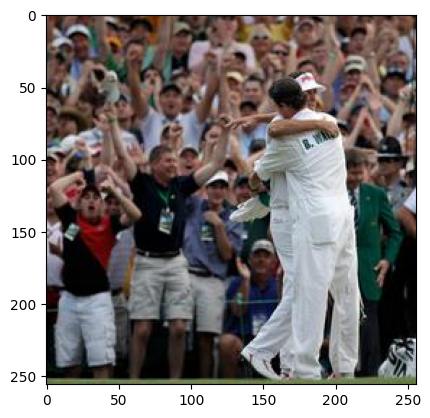

In [20]:
# Example usage
image_path = "/kaggle/input/news-image-caption-generation/images_50k/new_images/4fd101048eb7c8105d5bc251_0.jpg"
plt.imshow(Image.open(image_path))

text_data = fetch_visualgenome_attributes()[0:600]
top_words, top_probabilities = word_descriptor(image_path, text_data, num_top_words=3)

# Print top words and their probabilities
for word, probability in zip(top_words, top_probabilities):
    print(f"Word: {word}, Probability: {probability}")

#### Sentence level descriptors for an image

In [21]:
pip install accelerate

Note: you may need to restart the kernel to use updated packages.


In [22]:
pip install -i https://pypi.org/simple/ bitsandbytes

Looking in indexes: https://pypi.org/simple/
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 12.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install -q git+git@github.com:huggingface/transformers.git

ERROR: Invalid requirement: 'git+git@github.com:huggingface/transformers.git'
Hint: It looks like a path. File 'git+git@github.com:huggingface/transformers.git' does not exist.
Note: you may need to restart the kernel to use updated packages.


In [24]:
from PIL import Image
import requests
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")


2024-04-24 12:17:49.353702: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 12:17:49.353860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 12:17:49.501216: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [25]:
pip install transformers

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [26]:
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated caption: a man in white pants and a white shirt is hugging a man in white pants


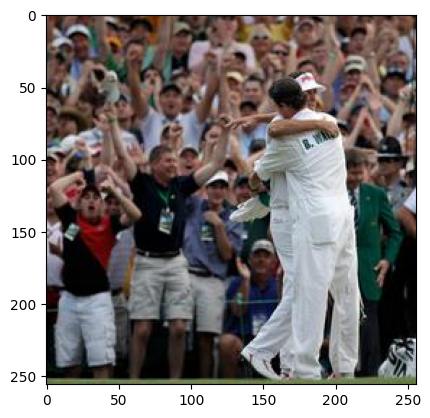

In [27]:
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch
from PIL import Image
import torchvision.transforms as transforms


# Generate caption for the image
def generate_caption(image_path):
    blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
    image = Image.open(image_path)
    inputs = blip_processor(image, return_tensors="pt")
    caption_ids = blip_model.generate(**inputs)
    caption = blip_processor.decode(caption_ids[0], skip_special_tokens=True)
    return caption

# Example usage

image_path ="/kaggle/input/news-image-caption-generation/images_50k/new_images/4fd101048eb7c8105d5bc251_0.jpg"
plt.imshow(Image.open(image_path))
abs_caption = generate_caption(image_path)
print("Generated caption:", abs_caption)


In [41]:
from transformers import pipeline, GPT2LMHeadModel, GPT2Tokenizer

# Load the pre-trained GPT-2 model and tokenizer
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2')
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Set the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt2_model.to(device)

# Define the caption generation pipeline
def generate_specific_caption(knowledge_assertions, caption_abstract, word_descriptors):
    # Combine the input components
    prompt = "\n".join(knowledge_assertions) + "\n" + caption_abstract + "\n" + " ".join(word_descriptors) + "\n"

    # Generate the caption using the pipeline
    caption_generator = pipeline("text-generation", model=gpt2_model, tokenizer=gpt2_tokenizer, device=0 if torch.cuda.is_available() else -1)
    generated_caption = caption_generator(prompt, max_length=len(prompt) + 100, num_return_sequences=3)
    
    #Remove the prompt from the generated caption
    # generated_caption = generated_caption.replace(prompt, '').strip()

    return str(generated_caption[0]['generated_text'].replace(prompt, '').strip()), str(generated_caption[1]['generated_text'].replace(prompt, '').strip()), str(generated_caption[2]['generated_text'].replace(prompt, '').strip())

# Example 
knowledge_assertions = [
    "the san francisco 49ers have a chance to win their third game of the season against the san francisco 49ers on tuesday",
    "the eagles have a chance to make a comeback, but the defense has a chance to make a comeback.",
    "the cleveland browns and the cleveland browns are in a tie for the nfl's most valuable player award.",
    "Tampa Bay's Jameis Winston has a chance to make a comeback in the nfl.",
    "scottish defender adolfo stubbs has a good season ahead of him, but he hasn't been able to keep up"
]
caption = "a man in white pants and a white shirt is hugging a man in white pants"
word_descriptors = ["celebratory", "hug", "all way"]

generated_caption_1, generated_caption_2, generated_caption_3 = generate_specific_caption(knowledge_assertions, caption, word_descriptors)
print(generated_caption_1.splitlines()[0])
print(generated_caption_2.splitlines()[0])
print(generated_caption_3.splitlines()[0])


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


and a guy in a black shirt is hugging a man in black jeans
scottish defender adolfo, who plays on the eagles, has been an extremely good year
the celtics go all the way with it


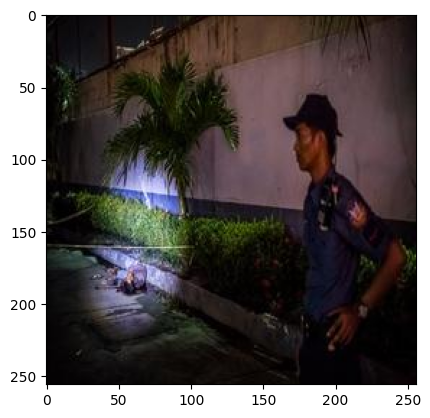

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=====Set 1 =====


[Input] knowledge assertion = ['people have been killed in a car crash in san antonio, texas, according to a news release.', 'a total of about 2,000 people have been killed in a riot in a city in the u.s. state of california.', 'unsolved killings in afghanistan have soared to more than 3,500, according to a new report.', 'a spokesman for the philippine police spokesman said he was not aware of a possible armed robbery in the philippines', 'police spokesman dionardo charles says he has been informed that a man has been arrested on suspicion of drug trafficking.', "sri lanka's president said tuesday that he's  very excited. ''", 'andanar said that about a third of the unsolved unsolved murders were committed by british police.', 'a spokesman for the philippine national police said tuesday that a pair of gunmen armed with a grenade were attempting to kill a policeman', 'National Police (P.N.P.) is now a state-owned police force in the state of tamil nadu.']

[Input] to

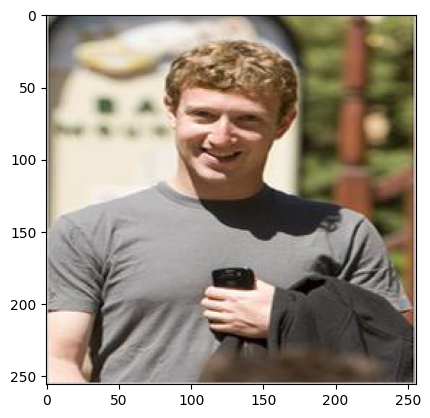

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=====Set 2 =====


[Input] knowledge assertion = ["a u.s. senate committee chairman says he's a partner in the u.s. senate.", 'a partner at the altimeter group, a digital telecommunications company, said tuesday that it is a partner at the company.', "social media giant fb slams u.s. gov t as a threat to the company's image, but analysts say it '", "augie ray says he's not sure if he's going to be able to get a job in the u.s..", "an analyst at forrester said friday that he is a long-time ally of the u.s. government's obama administration"]

[Input] top words = ['slider phone', 'cellular phone', 'pebble']

[Input] abstract caption = ["a u.s. senate committee chairman says he's a partner in the u.s. senate.", 'a partner at the altimeter group, a digital telecommunications company, said tuesday that it is a partner at the company.', "social media giant fb slams u.s. gov t as a threat to the company's image, but analysts say it '", "augie ray says he's not sure if he's going to be able t

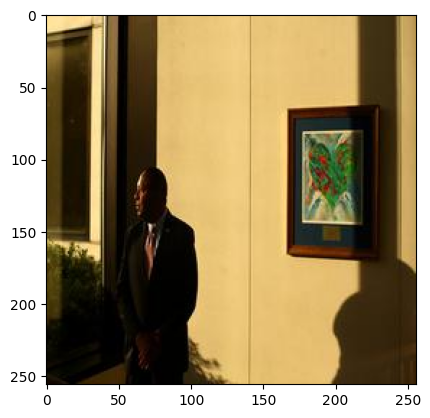

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=====Set 4 =====


[Input] knowledge assertion = ['a man has been arrested on suspicion of murder in the shootings of a woman and a man in south carolina, police said tuesday.', 'a white man named dylan roof posed with a black woman in a saturday night photo shoot.', 'a confederate soldier poses with the flag of the confederate states of america, a spokesman said tuesday.', "governor john haley said he's satisfied with the state's handling of the economy.", 'john m. smith, a u.s. senator, sat on the sidelines of a congressional hearing on the u.s. presidential election', 'on a hot afternoon, eight days, the sun was shining, and the sun was shining.', 'a hot afternoon on saturday lasted eight days, eight days after a heartwarming, emotional, emotional, emotional, emotional, emotional, emotional']

[Input] top words = ['sunlit', 'back lit', 'pierre versailles']

[Input] abstract caption = ['a man has been arrested on suspicion of murder in the shootings of a woman and a man in south car

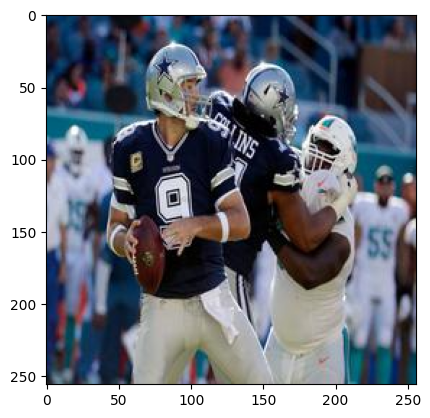

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=====Set 6 =====


[Input] knowledge assertion = ["the nfl's nfl's nfl's nfl's nfl's nf", 'the san francisco 49ers have a chance to win their third game of the season against the san francisco 49ers on tuesday', "a spokesman for the u.s. department of justice said a spokesman for the u.s. attorney general's office said a spokesman", "the nba's nba's nba's nba's nba's nb", 'the san francisco 49ers vs. the philadelphia phillies -lrb- sfl -rrb- will', 'the Baltimore Ravens will face the Cleveland Browns in a matchup on tuesday.', "the cleveland browns and the cleveland browns are in a tie for the nfl's most valuable player award.", 'the salich brothers on twitter at @5thDownFantasy', '@5thDownFantasy - @5thDownFantasy - @5thDownFantasy - @5th', '@5thDownFantasy - @5thDownFantasy - @5thDownFantasy - @5th', 'Matthew Stafford (DET) -- Matthew Stafford (DET) -- After Matthew Stafford (DET) -- After Matthew Stafford (DET) -- After Matthew Stafford (DET) --', "san antonio's san antonio's san a

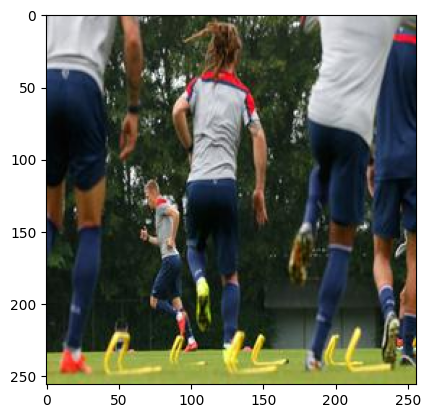

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=====Set 8 =====


[Input] knowledge assertion = ['cristiano ronaldo gave portugal a major confidence boost on tuesday.', 'a shrewd move to appoint a new coach, a new coach, a new coach, a new coach, a new coach, a', "cricket world's top scorer, nelson mandela, stepped up to the occasion with a one-day international against england.", 'the champions league -lrb- cfl -rrb- is back in action for the first time since the final of the final in may.', 'ronaldo ronaldo helped his team win the league final on tuesday.', 'ronaldo helped reignite Portugal on tuesday', "ronaldo helped reignite a stuttering attack on portugal's football team.", 'the san francisco 49ers beat the san francisco 49ers in a 5-1 romp, and the san francisco 49', 'ireland romps over ireland at MetLife stadium', 'iranian football team beats ireland in a friendly match at the MetLife Stadium in east rhodeford on tuesday.', 'Cristiano Ronaldo will play at the MetLife Stadium in East Rutherford, N.J.', "n.j. ronaldo, the wo

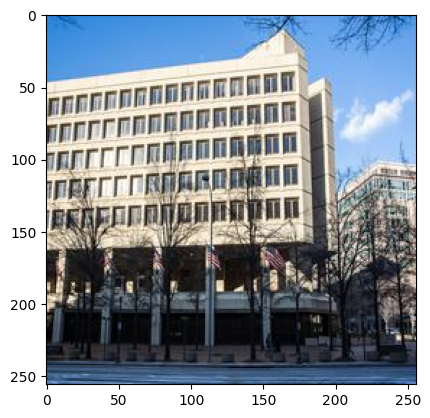

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=====Set 9 =====


[Input] knowledge assertion = ['the fbi has a number of agents in every department, including the u.s. department of justice, the u.s. attorney general', 'a u.s. government investigation has found a number of errors, including a mistake in a swiss computer system, a u.s. government', "the federal bureau of investigation is the backbone of the agency's investigative process, the u.s. government said tuesday.", 'the federal bureau of investigation has found that the u.s. government was storing more nuclear weapons than previously thought, according to a new report.', "two tons of valuables and two tons more drugs than the previous year's total, according to a new report from the u.s. department of justice.", "a review of more than 41,000 pieces of evidence from the u.s. government's investigation into the british embassy in sydney has concluded that british", 'the federal bureau of investigation is investigating a series of alleged bribery allegations in its offices a

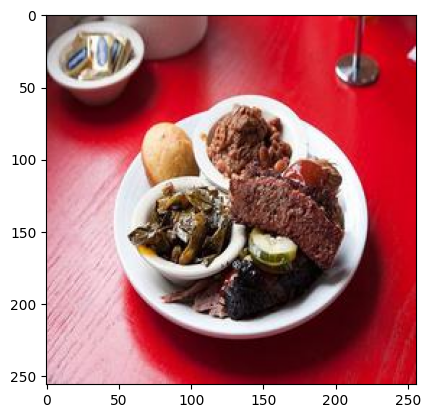

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=====Set 10 =====


[Input] knowledge assertion = ["if you're near Harrisburg, make a stop at a local coffee shop.", 'ShakeDown is a barbecue joint located at 668 firehouse road in san francisco, california.', 'firehouse road is a road in the town of Grantville, Pa.', 'shakedown bbq.com reports that a local bbq joint in grantville, pa., is preparing to open its doors for the first time', "sydney's sydney city centre is open all day friday and sunday.", 'the san francisco san francisco san francisco san francisco san francisco san francisco san', "a saturday's lunch is a saturday, a saturday, a saturday, a satur", "san francisco's san francisco san francisco san francisco san francisco san francisco", "if you're in the mood for a saturday night show, i'm here to help.", "if you're a fan of saturday night football, you're in luck.", 'the weekly special at hempen is a great way to spend a week.', 'weekly special at Hempen Hill BBQ (13208 Fountain)', 'hill BBQ is a popular place to eat in

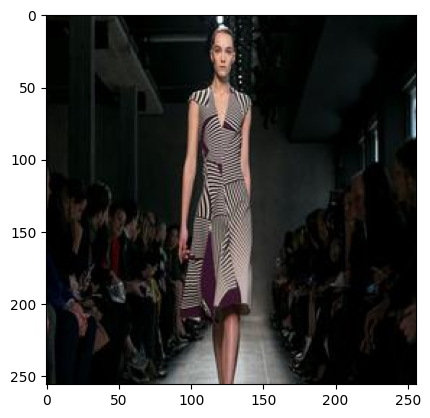

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=====Set 11 =====


[Input] knowledge assertion = ['michigan is taking a step forward, taking a step forward, taking a step forward, taking a step forward, taking a step forward', 'the caliber of Tomas maier at bottega veneta can be a lot higher than that of the other two.', 'at bottega veneta can pull off a big win.', 'winter 2014 trends: only the trends for winter 2014 -lrb- weather, weather, weather, weather, weather, weather, weather, weather, weather', "if you're looking for a new season of fashion, this is the place for you."]

[Input] top words = ['iron mesh', 'zebra pattern', 'mesh-covered']

[Input] abstract caption = ['michigan is taking a step forward, taking a step forward, taking a step forward, taking a step forward, taking a step forward', 'the caliber of Tomas maier at bottega veneta can be a lot higher than that of the other two.', 'at bottega veneta can pull off a big win.', 'winter 2014 trends: only the trends for winter 2014 -lrb- weather, weather, weather, weather

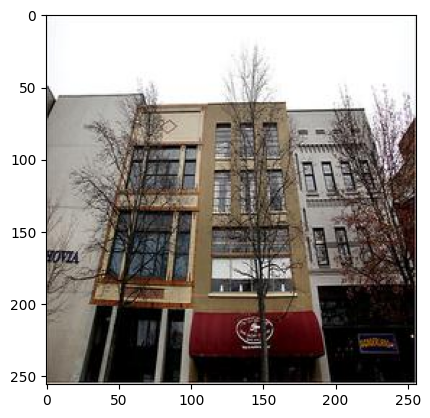

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=====Set 13 =====


[Input] knowledge assertion = ['the u.s. federal reserve said tuesday it will raise the amount of money it will spend to pay for a u.s.-led', 'a new york city condo has been sold for $274,900, according to a new york real estate website.', 'a condo and a unit of street are being sold in a san francisco suburb, a spokesman said tuesday.', 'a condo in san antonio, california, is one of nine apartments in a san antonio,', 'one of nine apartments in an apartment complex in san francisco, california, is one of nine apartments in an apartment complex in san franci', 'an apartment building in downtown chicago, illinois, was built in 1885.', 'a building in downtown asheville', 'a new condo building has been converted into a hotel, according to a news release from the city of san antonio -lrb-', 'a new store opened in asheville on tuesday.', 'asheville vs. the blue ridge -lrb- tv -rrb- -lrb- tv -rrb-', 'the Great Smoky Mountains are a mountain range in the northwestern part

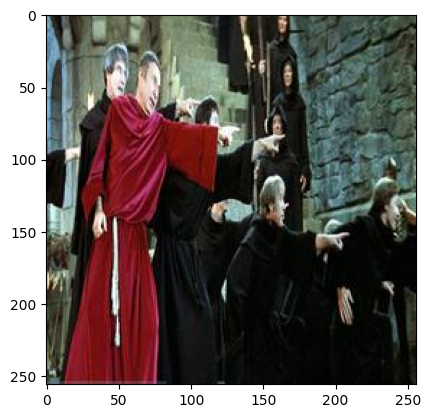

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=====Set 14 =====


[Input] knowledge assertion = ['the san francisco bay area is celebrating its 35th anniversary this year.', 'this year marks the 35th anniversary of the san francisco earthquake and tsunami.', '"history of the world, part i" is a book about the history of the world.', '', "a cameo by mel brooks in a  saturday night show '' was a  saturday night ''", "Janet Maslin reviews the history of the  saturday night live '' show.", 'the best way to make a living is to make a living, and this is the best way to make a living.', '', "san diego's  22 '' is set to open at syndicated theater on tuesday.", 'a new restaurant and a bar in a Brooklyn neighborhood has opened.', "a saturday night showdown between san francisco's san francisco san francisco's san fr", "michael broncos, who have won the nfl's olympic gold medal, will begin a week with the oly", "the movie that evening was a  sample gag. ''", 'three people were killed in a mountain blaze on tuesday, a spokesman said.']

[I

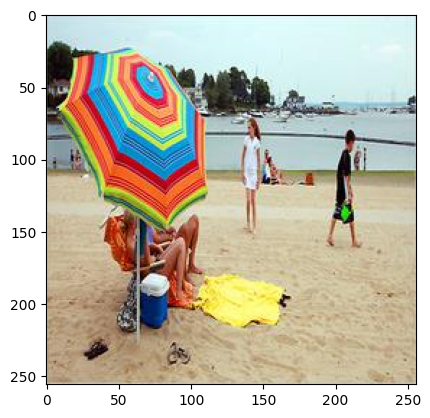

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=====Set 15 =====


[Input] knowledge assertion = ['mamaroneck has more variety than any other community in the state, according to a new report.', 'census-designated place -lrb- cdp -rrb- -lrb- cdp -rrb- has a', 'a survey of 18,400 residents in the u.s. state of california showed that 18 percent of residents described themselves as white.', 'a spokesman for the u.s. department of homeland security said a spokesman for the u.s. department of homeland security said a spokesman for', 'u.s. census-designated places -lrb- cdp -rrb- have a higher percentage of Hispanics than blacks,', 'chinese people are more likely to vote in the u.s. presidential election than in other countries, according to a new poll.', "chinese president jiang zemin said tuesday that he's confident that he will win the election.", 'a spokesman for the u.s. embassy in beijing says a spokesman for the u.s. embassy in beijing says a', "san francisco's san francisco's san francisco's san francisco's san", "car, Steve Odi

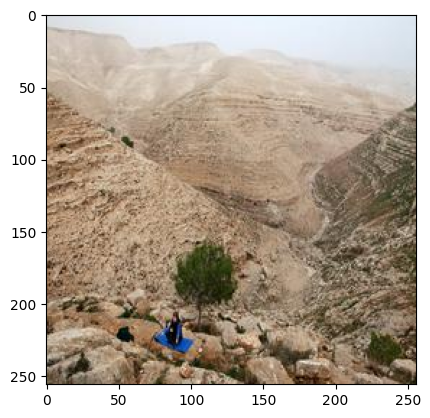

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=====Set 16 =====


[Input] knowledge assertion = ['israeli troops have attacked a village in the west bank city of ramallah, west bank officials said tuesday.', 'sometimes life can be hard, sometimes it can be good, sometimes it can be bad, sometimes it can be good, sometimes it can be good, sometimes it can be bad', 'a photographer has been killed in a car crash, police said tuesday.', "palestinian leader ahmadinejad said he's happy to see a palestinian woman's joy and light shine through the streets of palestinian", 'israeli government says it has stepped up security measures in the occupied territories, a senior official said tuesday.', 'the west bank and the gaza strip are under Israeli restrictions, a senior official said tuesday.', "the west bank and the Gaza Strip -- was supposed to be a part of israel's war against israel, israeli officials said tuesday.", 'israeli customs chief ariel sharon said tuesday that israeli customs chief ariel sharon was  a', "israel's prime ministe

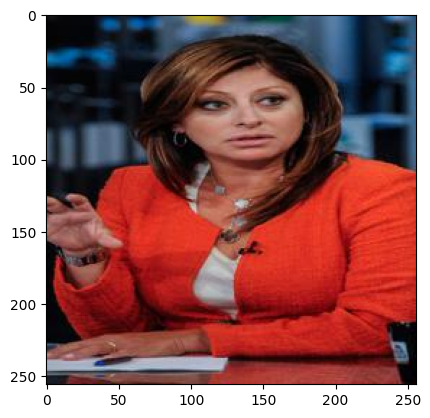

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=====Set 18 =====


[Input] knowledge assertion = ['maria bartiromo, one of the most famous women in the world, is one of the most famous women in the world.', "first women's tennis player to win a world title, maria bartiromo is one of the first women's tennis players to win a world title", 'one of the first women to become a u.s. president is a woman, a u.s. official said tuesday.', "cnbc's rival tv network's rival tv network is a longtime home for its rival tv network.", 'a rival to the fox business network has been confirmed by cnn.', "cnbc's business network has confirmed the news of a new tv show that will air on cnbc on tuesday", 'michael jackson confirmed the news tuesday.', 'president barack obama congratulated russian presidential candidate michael bartiromo on his 20th birthday.', "sarah bartiromo's 20-year career at cnbc is over.", 'cnn.com -lrb- cnn.com -rrb- -lrb- cnn.com -r', "i'm going to be able to do it again, i'm going to be able to do it again, i'm going to be", "M

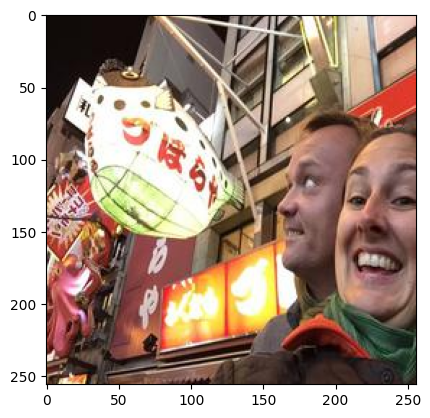

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=====Set 20 =====


[Input] knowledge assertion = ['michael adams won a gold medal at the 2012 summer olympics.', 'british actress british actor british actor british actor british actor british actor british actor british', 'eric and amber hoffman have downsized their lives.', 'a spokesman for the u.s. embassy in washington, D.C., said a spokesman for the embassy in washington', 'in d.c., by selling it.', 'a u.s. passenger on a one-way flight from san francisco to san antonio, texas', 'a flight to ireland is on its way.', "san francisco police chief says he hasn't seen a police officer since he was arrested in a robbery.", 'san francisco, california, and san francisco, california -lrb-', 'a juggle player grew up in new jersey, and now juggles in san francisco, california.', "the world's leading hospitality brands are in the spotlight in asia and Europe, according to a new report by the asia news agency -lrb- a", "a spokesman for the european union's foreign minister said a spokesman 

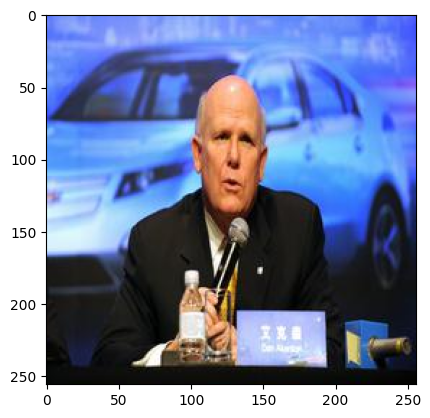

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=====Set 21 =====


[Input] knowledge assertion = ['president clinton said he was confident he would be able to win the election if he wins the nomination.', "g.m. said he's confident in g.m.'s ability to win the olympics.", 'u.s. crude oil prices surged in the first quarter of 2008, peaking at a record high.', 'oil prices soared tuesday, averaging $145 a barrel.', 'a barrel is a barrel, a barrel is a barrel, a barrel is a barrel, and a barrel is a barrel.', 'u.s. retail sales plunged 27 percent at a time, dealers said tuesday.', "president john m. kennedy says he's a democrat, a democrat, a democrat, a democrat", "i 'd like to say that i 'd like to say that i 'd like to say that i 'd like to say that i 'd like to say"]

[Input] top words = ['used car dealer', 'rotary', 'price labelled']

[Input] abstract caption = ['president clinton said he was confident he would be able to win the election if he wins the nomination.', "g.m. said he's confident in g.m.'s ability to win the olympics.

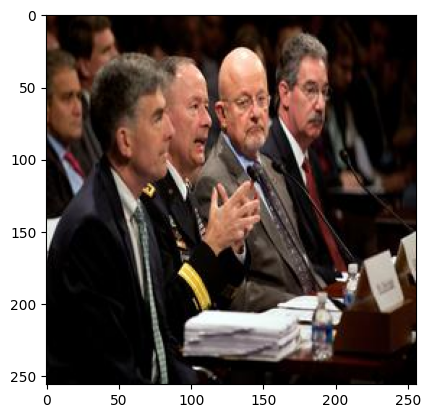

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=====Set 26 =====


[Input] knowledge assertion = ['spying on the united states is a serious problem, a u.s. official said tuesday.', 'when i was a kid, i was a kid, and i was a kid, and i was a kid, and i was', 'robert h. mcdonald, a former intelligence officer who served as a u.s. ambassador to the united arab emir', "president clinton says he's ready to go to the u.s. presidential election.", "iranian officials defended their positions, saying they're  defending our country's interests. ''", "the u.s. house intelligence committee's operations before the house intelligence committee at a time when the u.s. house intelligence committee's operations before the u.s. house intelligence committee", 'the n.s.a. has come under a lot of scrutiny over the past few years.', 'americans who were born in the united states were also american citizens who were born in the united states, a u.s. official said tuesday.', 'americans are determined to protect their privacy while identifying themselves 

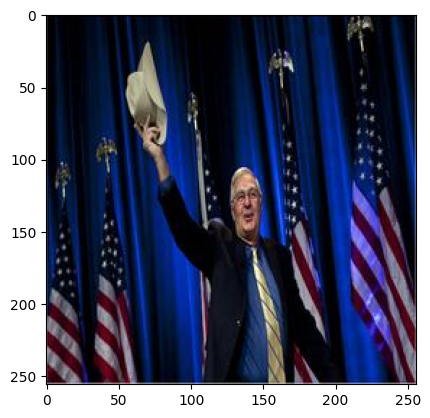

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=====Set 27 =====


[Input] knowledge assertion = ["state senator, he said he's not going to be a democrat, he's going to be a democrat, he's", 'president george w. bush, a former u.s. secretary of state and a former u.s. secretary of state, has been sworn in', 'a spokesman for the u.s. house of representatives said a spokesman for the u.s. house of representatives said a spokesman for the', "if you're a republican, you're a republican, and if you're a republican, you're a republic", 'a new republican, a real republican, a real republican, a real republican, a real republican, a real republican', 'a real republican is a real republican, a real republican is a real republican, a real republican is a real republican', 'if democrats want evidence, they need it.']

[Input] top words = ['pierre versailles', 'bush', 'throwing frisbee']

[Input] abstract caption = ["state senator, he said he's not going to be a democrat, he's going to be a democrat, he's", 'president george w. bush, a former

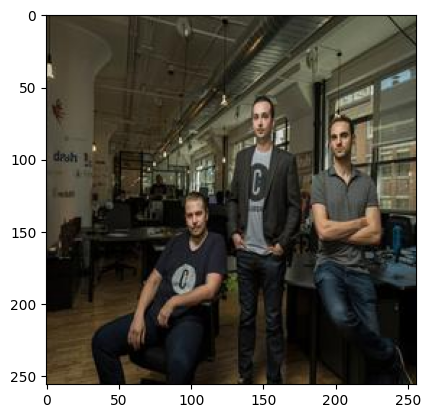

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=====Set 28 =====


[Input] knowledge assertion = ["if you've ever watched  shark tank '', you'll know that you've seen it a million times.", "if you're looking for a new land, you've come to the right place : collaborizm.", "president clinton says he's ready to go to war with iraq, but he's not ready to go to war.", "i'm not a snob, i'm a snob, i'm a snob", 'collaborizm, a software company based in san francisco, has a net worth of less than a billion dollars.']

[Input] top words = ['mens', 'corporate', 'small portion of']

[Input] abstract caption = ["if you've ever watched  shark tank '', you'll know that you've seen it a million times.", "if you're looking for a new land, you've come to the right place : collaborizm.", "president clinton says he's ready to go to war with iraq, but he's not ready to go to war.", "i'm not a snob, i'm a snob, i'm a snob", 'collaborizm, a software company based in san francisco, has a net worth of less than a billion dollars.']

actual caption = From

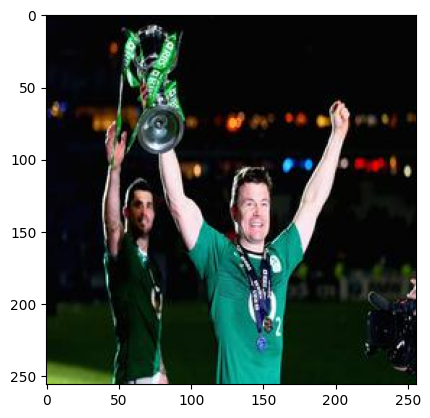

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=====Set 29 =====


[Input] knowledge assertion = ["iraqi president john mccain said tuesday he 'd like to see a  scarcity '' in the", "it's always a good thing to win the championship, but it's always a good thing to win the championship.", 'the five long-established british british colonies have won a series of battles over the past few years.', "san francisco's san francisco san francisco's san francisco san francisco san franci", 'the san diego chargers won the san diego chargers in the 132nd annual san diego chargers championship.', 'april 11th in the 132-year-old tournament, april 11th in the 132-year-old tournament, april 11', 'the san diego chargers have given the san diego chargers the most money in the history of the san diego chargers.', 'samuel harris has been sent off to his 141-match career.', 'british prime minister john mccain has denied he and ireland in the past.', 'iranian president robert mccain has re-elected a former republican to the post of president of the rep

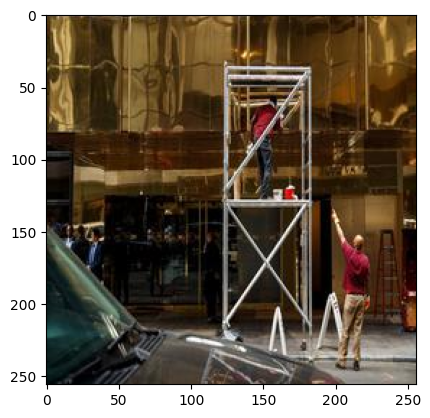

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=====Set 30 =====


[Input] knowledge assertion = ["the area around the Trump Tower during president clinton's presidency", "u.s. president clinton toured the world's tallest building, the world's tallest building, on tuesday,", 'the city of san francisco will be closed from saturday to saturday due to a power outage, officials said tuesday.', "wednesday's olympic games will begin at midnight.", 'at midnight on sunday, 58th and 55th streets will be closed.', '58th and 55th streets will be reopened on tuesday.', 'traffic is expected to increase on a saturday as the u.s. presidential election draws to a close, officials said.', 'a spokesman for the u.s. department of transportation said a spokesman for the u.s. department of transportation said a spokesman for the u', '56th Street between Fifth and Sixth Avenues was closed on tuesday.', 'sixth avenues is a major thoroughfare between the boroughs of san francisco, california, and san francisco', 'the police will remain open on fifth aven

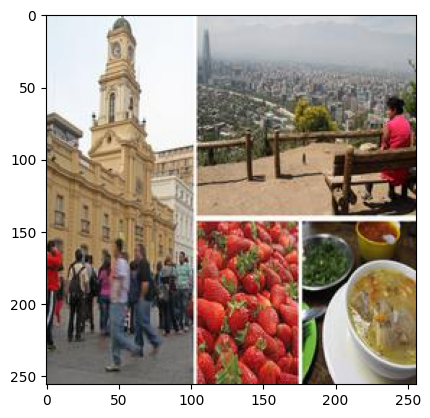

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=====Set 32 =====


[Input] knowledge assertion = ['mexican president barack obama has invited venezuelan president barack obama to dinner.', 'the subway to la fuente alemana, a legendary', 'pork loin and lomito (pork loin and pork loin ) are the two most popular dishes in the u.s., according to a new study', "if you want to make a sandwich, you'll have to assemble it.", 'two sandwiches and two beers cost me a lot of money.', 'beers cost me 13,300 pesos.', "thank you for two nights'lodging.", 'i left him and set out for san francisco.', 'rodrigo cea is out to meet a Chilean.', 'a chilean traveller has been arrested in a san francisco airport, police said saturday.']

[Input] top words = ['small portion of', 'travel', 'eastern']

[Input] abstract caption = ['mexican president barack obama has invited venezuelan president barack obama to dinner.', 'the subway to la fuente alemana, a legendary', 'pork loin and lomito (pork loin and pork loin ) are the two most popular dishes in the u.s.,

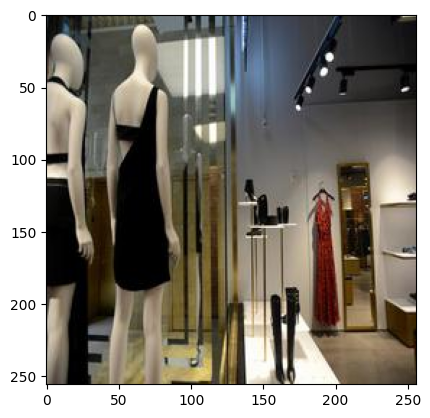

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=====Set 33 =====


[Input] knowledge assertion = ['in a deal worth a record amount, versace said it would sell the brand for a record amount of money in the first half of the year.', 'a new car was sold at a car show in san francisco on tuesday, according to a press release from Versace.', 'versace has sold a 20 percent stake in the san marino racing team.', 'the blackstone group has acquired a stake in a private equity firm, according to a news release.', "a release from the two parties said saturday that saturday's match against san antonio's team was a success.", "saturday's sports scoreboard : saturday's sports scoreboard : saturday's sports scoreboard : saturday", "saturday's sports scoreboard : Versus Versace -lrb- tv -rrb- -lrb- tv", 'a slew of sex scandals, scandals, scandals, scandals, scandals, scandals, scandals, scandals, scandals,', "new york's Versace has opened a new store in san francisco, a year after it opened a store in san francisco", 'a stand-alone store on a san

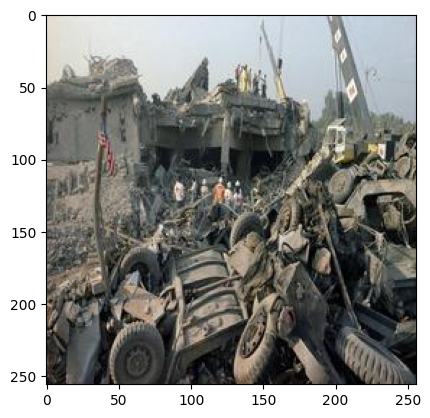

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=====Set 34 =====


[Input] knowledge assertion = ['the supreme court on wednesday ruled that a british man accused of murdering a british woman has been convicted of murder.', "the u.s. supreme court on wednesday started with a unanimous decision on a case involving a woman's right to vote.", 'a lawsuit against the u.s. embassy in san francisco, california, against the embassy in san francisco', 'the families of the victims of the iraq war have filed a lawsuit against the u.s. embassy in iran.', "some of the 241 servicemen who were killed in the u.s. military's war in iraq have been released, officials said wednesday", 'the u.s. marines bombed a barracks in san francisco on tuesday, a u.s. official said.', 'u.s. marine barracks in beirut', 'marine barracks in beirut -lrb- bbc -rrb- -lrb- bbc -rrb-', 'a federal government in beirut imposed a ban on the sale of tobacco products in the city, a government spokesman said tuesday.', 'a federal judge ruled tuesday that iran was liable for h

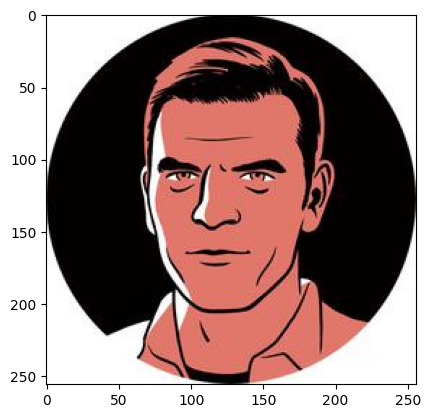

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=====Set 35 =====


[Input] knowledge assertion = ['bookends is a weekly newspaper in san francisco, california.', 'bookends is a weekly literary magazine published by the university of california at berkeley.', "bookends is a book about a young woman's struggle to find meaning in her life, a book about a woman's struggle to find meaning in", "james p. pierce's latest book, '' '' '' '' '' '' '' ''", 'James Parker and Anna Holmes have been in the news for a long time.', 'james parker and anna holmes discuss whether they have a relationship', "if you're a fan of the tv show, you're going to love it.", "you can't go wrong here.", 'a new york city-based bookstore is introducing a new series of books to the public.']

[Input] top words = ['bust', 'falcon', 'davy']

[Input] abstract caption = ['bookends is a weekly newspaper in san francisco, california.', 'bookends is a weekly literary magazine published by the university of california at berkeley.', "bookends is a book about a young woman

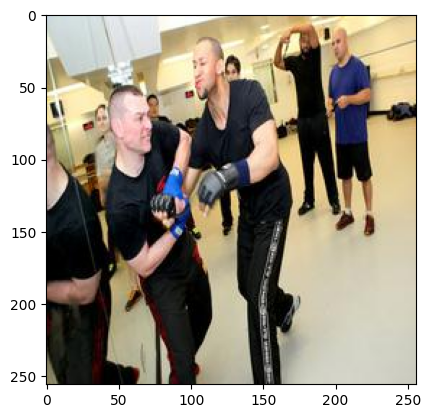

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=====Set 36 =====


[Input] knowledge assertion = ["a spokesman for the russian government said thursday that the institute's students are grouped in the  russian academy of arts ''.", '', "israel's army has been using a grenade in training since a grenade was launched, a spokesman said tuesday", 'military training since the 1940s.', 'grappling is a martial art, and it is a sport that has been practiced for centuries.', 'a class in a midtown studio on a recent weeknight, a class in a midtown studio on a recent weeknight, a class in a midtown studio', 'a british man has been arrested after a british police officer threw a grenade at a british soldier.']

[Input] top words = ['knelt', 'shielding', 'split in the center']

[Input] abstract caption = ["a spokesman for the russian government said thursday that the institute's students are grouped in the  russian academy of arts ''.", '', "israel's army has been using a grenade in training since a grenade was launched, a spokesman said tuesd

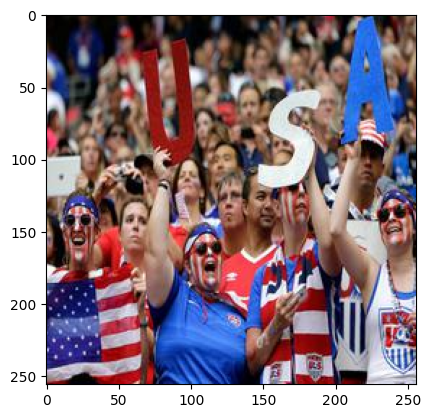

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=====Set 37 =====


[Input] knowledge assertion = ["new york city is to hold a symphony of music, which will be held on saturday, according to a news release from the city's", 'a tape parade for the united arab emirates will be held on friday for the united arab emirates.', "the women's national basketball team will compete in the women's national basketball tournament at the u.s. women's national basketball tournament in san francisco.", 'a new york city-based company, a new york city-based company, announced thursday that it has acquired a majority stake in a new york city-', 'the san francisco 49ers are preparing for a home game against the san francisco 49ers on tuesday, two days after the team', 'world cup : the world cup : the world cup : the world cup : the world cup : the world cup : the world cup : the world cup : the', 'the office of mayor bill de larsio said on tuesday that he will not seek re-election unless he wins a re-election.', "san francisco's san francisco national 

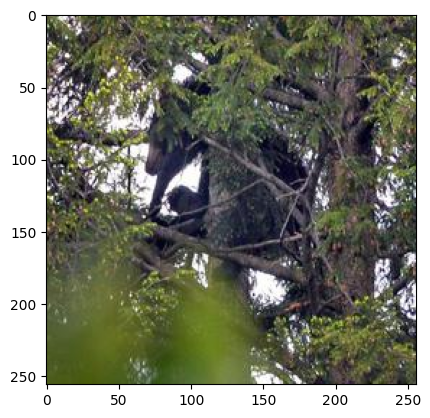

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=====Set 38 =====


[Input] knowledge assertion = ['so went the last days of the so.', "the  renegade '' of the u.s. senate, the  renegade '' of the u.s", 'it was a good day, but it was also a bad day, as the u.s. presidential election was put down on wednesday.', 'the u.s. embassy in san francisco denounced a two-day event tuesday, saying it was a two-day', 'the governor of the city of albany is electrified, electrified and electrified, and electrified, and electrified, and electrified', 'a u.s. government official said tuesday that a u.s. government investigation into a u.s. nuclear program has begun.', 'the little town of Bethlehem, N.Y., is a small town in the northern portion of the state of new york.', 'a spokesman for the state of new york said a spokesman for the state of new york said a spokesman for the state of new york said a']

[Input] top words = ['falling off tree', 'hanging still', 'possibly juvenile']

[Input] abstract caption = ['so went the last days of the so.', "t

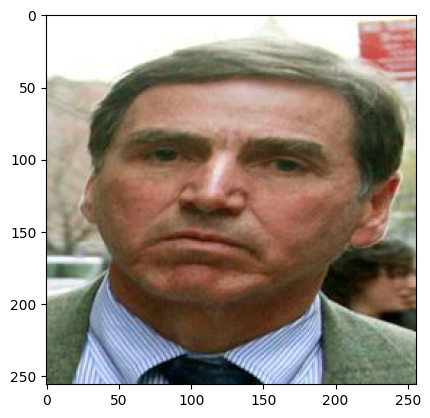

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



=====Set 40 =====


[Input] knowledge assertion = ["u.s. defenseman says he's ready to go to the u.s. senate if he wins a senate election.", "a prosecutor in the district attorney's office of the city of manhattan has been sworn in, a prosecutor said wednesday.", 'police officer michael pena has been charged with a felony robbery.', 'a jury in the u.s. supreme court ruled tuesday that a woman raped a man in a slum in', 'a convicted felon, he was sentenced to life in prison for a mistrial, prosecutors said friday.', 'jurors in a u.s. trial for the murder of a woman in a san francisco courtroom on tuesday ruled that', 'jurors in a san francisco murder trial declined to take part in a jury trial, a spokesman said tuesday.', "pena's lawyer said friday he would convict him on rape charges if convicted.", "a u.s. congressman says he's a member of the u.s. house of representatives, but he's not a member"]

[Input] top words = ['bib', 'older man', 'bush']

[Input] abstract caption = ["u.s. de

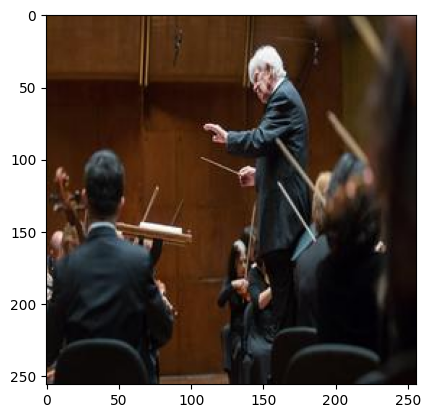

In [ ]:
image_path_root = "/kaggle/input/news-image-caption-generation/images_50k/new_images"

def get_first_n_words(sentence, n):
    words = sentence.split()
    if len(words) <= n:
        return sentence
    else:
        return " ".join(words[:n])
    
i = 0    
for key in keys:
    i = i + 1
    caption = caption_data.get(key)["image"]
    article = caption_data.get(key)["article"]
    
    j = 0
    caption = caption['0']
    if caption is None or len(caption) == 0 or len(caption.strip()) == 0:
        continue
    
    article_trimmed = get_first_n_words(article, 100)
    ner, entity_contexts = extract_entity_contexts_with_ner(article_trimmed)
    knowledge_prompt = generate_knowledge_prompts(entity_contexts)
    knowledge_assertions = []
    
    for prompt in knowledge_prompt:
        t = generate_knowledge_assertions(prompt)[0]
        t = "".join(t)
        knowledge_assertions.append(str(t))
    
    image_path = image_path_root + f"/{key}_{j}.jpg"
    plt.imshow(Image.open(image_path))
    plt.show()
    text_data = fetch_visualgenome_attributes()[0:1000]
    top_words, top_probabilities = word_descriptor(image_path, text_data, num_top_words=3)
    
    caption_abstract = generate_caption(image_path)
    k = min(5, len(knowledge_assertions))
    generated_caption_1, generated_caption_2, generated_caption_3 = generate_specific_caption(knowledge_assertions[:k], caption_abstract, top_words)
    
    print ("\n=====Set " + str(i) + " =====\n")
    print ("\n[Input] knowledge assertion = " + str(knowledge_assertions))
    print ("\n[Input] top words = " + str(top_words))
    print ("\n[Input] abstract caption = " + str(knowledge_assertions))
    
    print ("\nactual caption = " + str(caption))
    print ("generated caption 1 & BLEU score = " + generated_caption_1.splitlines()[0] + " " + str(sentence_bleu(str(caption), generated_caption_1)))
    print ("generated caption 2 & BLEU score = " + generated_caption_2.splitlines()[0] + " " + str(sentence_bleu(str(caption), generated_caption_2)))
    print ("generated caption 3 & BLEU score = " + generated_caption_3.splitlines()[0] + " " + str(sentence_bleu(str(caption), generated_caption_3)))